## Initial Setup

### Import necessary libraries

In [504]:
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import py7zr
import os
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from rpca import RPCA

### Decompress the .mat file if it is compressed

Following patient data and its quality:
- `S1.mat` $\rightarrow$ good patient data
- `S3.mat` $\rightarrow$ good patient data
- `S31.mat` $\rightarrow$ good patient data
- `S32.mat` $\rightarrow$ good patient data
- `S19.mat` $\rightarrow$ medium patient data
- `S29.mat` $\rightarrow$ bad patient data

In [505]:
subject = 1

# Path to the compressed file
compressed_file = f'S{subject}.mat.7z'
mat_file = f'S{subject}.mat'

# Check if the .mat file already exists
if os.path.exists(mat_file):
    print(f"Using existing file {mat_file}")
# Check if the compressed file exists
elif os.path.exists(compressed_file):
    # Extract the file
    with py7zr.SevenZipFile(compressed_file, mode='r') as z:
        z.extractall()
    print(f"Successfully extracted {compressed_file}")
else:
    print(f"File {compressed_file} not found")

Using existing file S1.mat


### Load the .mat file

In [506]:
# S1.mat # good patient data
# S3.mat # good patient data
# S19.mat # medium patient data
# S29.mat # bad patient data
# S31.mat # good patient data
# S32.mat # good patient data

eeg_data = sio.loadmat(mat_file)['data']

### Define useful global variables

In [507]:
frequency_to_index = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7,
    8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15,
    8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23,
    8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31,
    8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39,
}

samples = 250 # 250 samples analyzed at once
spacing = 4  # time between samples in ms
fs = 250  # 250 Hz sampling rate


time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000
default_freq_xlim = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

selected_channels = {
    "Pz": 47,
    # "PO5": 53,
    # "PO3": 54,
    "POz": 55,
    # "PO4": 56,
    # "PO6": 57,
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

trial = 4
evoked_frequency = 8
start_sample = 375
end_sample = 625

### Define useful functions

In [508]:
## Data Extraction
def get_electrodes_data(eeg_data, trial, frequency, selected_channels, start_sample, end_sample):
    """
    Extract electrodes data for selected channels within a defined sample interval.
    
    Args:
        eeg_data: The EEG data matrix
        trial: Trial number (1-indexed)
        frequency: Frequency value in Hz
        selected_channels: Dictionary mapping channel names to indices
        start_sample: Starting sample index
        end_sample: Ending sample index
        
    Returns:
        Numpy array containing electrodes data for selected channels
    """
    frequency_index = frequency_to_index[frequency]
    electrodes_data = eeg_data[:, :, frequency_index, trial - 1]
    return electrodes_data[list(selected_channels.values()), start_sample:end_sample]


## Plotting
def plot_time_frequency(data_matrix, title_prefix, channels, 
                        time_range=time_range, freq_range=freq_range, frequency=None, 
                        figsize=(15, 10), freq_xlim=default_freq_xlim, show_grid=True):
    """
    Plot electrode data in both time and frequency domains.
    
    Args:
        data_matrix: Matrix containing electrode data with shape (electrodes, samples)
        title_prefix: Prefix string to add to plot titles
        channels: Dictionary mapping channel names to indices
        time_range: Array for time domain x-axis (default: global variable time_range)
        freq_range: Array for frequency domain x-axis (default: global variable freq_range)
        samples: Number of samples for FFT calculation (default: data_matrix.shape[1])
        frequency: Frequency value to display in title (default: global variable frequency)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
        freq_xlim: Tuple for frequency plot x-axis limits (default: (5, 35))
        show_grid: Whether to show grid on frequency plots (default: True)
        
    Returns:
        fig, axes: The figure and axes objects for further customization
    """
    electrode_indices = [i for i in range(len(selected_channels))]
    samples = data_matrix.shape[1]
    
    # Create subplot grid with enough columns for all electrodes
    n_electrodes = len(electrode_indices)
    fig, axes = plt.subplots(2, n_electrodes, figsize=figsize)
    
    # Handle case of single electrode (axes won't be 2D)
    if n_electrodes == 1:
        axes = axes.reshape(2, 1)

    for i, electrode_index in enumerate(electrode_indices):
        electrode_data = data_matrix[electrode_index, :]
        electrode_fft = 2 / samples * np.abs(fft(electrode_data)[0 : samples // 2])

        # Time domain plot
        axes[0, i].plot(time_range, electrode_data)
        axes[0, i].set_xlabel("Time (ms)")
        axes[0, i].set_ylabel("Voltage (uV)")
        
        # Set title with channel name if available
        title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                title += f" - {channel_names[electrode_index]}"
        if frequency is not None:
            title += f" Potential for {frequency} Hz"
        axes[0, i].set_title(title)

        # Frequency domain plot
        freq_title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                freq_title += f" - {channel_names[electrode_index]}"
        freq_title += " Freq Distribution"
        if frequency is not None:
            freq_title += f" for {frequency} Hz"
        axes[1, i].set_title(freq_title)
        
        axes[1, i].plot(freq_range, electrode_fft)
        axes[1, i].set_xlabel("Frequency (Hz)")
        axes[1, i].set_ylabel("FFT Magnitude")
        
        if freq_xlim:
            # Set the x-axis limits to show from the first to the last value in freq_xlim
            if isinstance(freq_xlim, (list, tuple)) and len(freq_xlim) >= 2:
                axes[1, i].set_xlim(freq_xlim[0], freq_xlim[-1])
            
            # Add vertical grid lines at each frequency in freq_xlim
            if isinstance(freq_xlim, (list, tuple)):
                axes[1, i].set_xticks(freq_xlim)
                axes[1, i].grid(axis='x', linestyle='-', alpha=0.7)
            
        if show_grid:
            # Add regular grid for y-axis
            axes[1, i].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    return fig, axes


## Power Spectral Density Analysis
def power_spectral_density_welch(data_matrix, fs, start_sample, end_sample, nperseg=None):
    """
    Compute the Power Spectral Density (PSD) using Welch's method.

    Args:
        data_matrix: EEG data (channels, samples)
        fs: Sampling frequency (Hz)
        start_sample: Start index
        end_sample: End index
        nperseg: Segment length for Welch (default: fs/2)

    Returns:
        freqs (1D array), psd_values (2D array: channels x frequencies)
    """
    data_segment = data_matrix[:, start_sample:end_sample]
    
    if nperseg is None:
        nperseg = fs // 2  # Default to 0.5s segments

    freqs, psd_values = welch(data_segment, fs=fs, nperseg=nperseg, axis=1, window='hann')

    return freqs, psd_values

def calculate_band_to_total_ratio(
        data_matrix, fs=fs, start_sample=None, end_sample=None, evoked_frequency=evoked_frequency, band_width=1
    ):
    """
    Calculate the ratio of power in a frequency band centered on the evoked frequency
    to the total power in the 5-35 Hz range.
    
    Args:
        data_matrix: Matrix containing electrode data
        fs: Sampling frequency in Hz (default: global variable fs)
        start_sample: Starting sample index (default: 0)
        end_sample: Ending sample index (default: data_matrix.shape[1])
        evoked_frequency: Center frequency of the band of interest (default: global variable evoked_frequency)
        band_width: Width of the frequency band in Hz (default: 1 Hz)
        
    Returns:
        Ratio of band power to total power for each channel
    """
    if start_sample is None:
        start_sample = 0
    if end_sample is None:
        end_sample = data_matrix.shape[1]

    # Get frequencies and PSD
    freqs, psd_values = power_spectral_density_welch(data_matrix, fs, start_sample, end_sample)

    # Define frequency ranges
    total_range_mask = (freqs >= 5) & (freqs <= 35)
    band_range_mask = (freqs >= evoked_frequency - band_width/2) & (freqs <= evoked_frequency + band_width/2)
    
    # Calculate power in the specified ranges for each channel
    n_channels = psd_values.shape[0]
    ratios = np.zeros(n_channels)
    
    for channel_idx in range(n_channels):
        # Sum power in the total range (5-35 Hz)
        total_power = np.sum(psd_values[channel_idx, total_range_mask])
        
        # Sum power in the band around evoked frequency
        band_power = np.sum(psd_values[channel_idx, band_range_mask])
        
        # Calculate ratio
        ratios[channel_idx] = band_power / total_power if total_power > 0 else 0
    
    return ratios

def display_power_ratios_table(original_ratios, l_ratios, s_ratios, channel_names=None):
    """
    Create and display a pandas DataFrame showing band-to-total power ratios.
    
    Args:
        original_ratios: Band-to-total power ratios for original data
        l_ratios: Band-to-total power ratios for L component
        s_ratios: Band-to-total power ratios for S component
        channel_names: Optional list of channel names (default: Channel 1, Channel 2, etc.)
    
    Returns:
        pandas DataFrame with the ratios
    """
    import pandas as pd
    
    # Create the DataFrame
    df = pd.DataFrame({
        'Original': original_ratios,
        'L component': l_ratios,
        'S component': s_ratios
    })
    
    # Rename columns to represent channels
    df.columns.name = 'Component'
    
    # Set channel names if provided, otherwise use default naming
    if channel_names is None:
        channel_names = [f'Channel {i+1}' for i in range(len(original_ratios))]
    
    df.index = channel_names
    df.index.name = 'Channel'
    
    # Return the transposed DataFrame (components as rows, channels as columns)
    return df.T



## Iteration over $\mu$ and $\lambda$ values


In [ ]:
lamb_zero = 1 / np.sqrt(end_sample - start_sample)

mu_denominators = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

lamb_values = [lamb_zero, lamb_zero / 2, lamb_zero / 3, lamb_zero / 4,
               lamb_zero / 5, lamb_zero / 6, lamb_zero / 7, lamb_zero / 8,
               lamb_zero / 9, lamb_zero / 10, lamb_zero / 15, lamb_zero / 20,
               lamb_zero / 25, lamb_zero / 30, lamb_zero / 35
            ]

# Initialize variables to track the best parameters before the loops
best_mu = None
best_lamb = None
max_L_to_original_ratio = 0
max_S_to_original_ratio = 0

for j, lamb in enumerate(lamb_values):
    for i, mu_denominator in enumerate(mu_denominators):
        mu = lamb / mu_denominator
        
        X = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)
        L, S = RPCA(X, lamb, mu, tolerance=10e-4, max_iteration=1000)

        electrode_data_filtered_L = L
        electrode_data_filtered_S = S
        
        # Calculate ratios for original data and filtered components
        original_ratios = calculate_band_to_total_ratio(X)
        L_ratios = calculate_band_to_total_ratio(electrode_data_filtered_L)
        S_ratios = calculate_band_to_total_ratio(electrode_data_filtered_S)

        # Display the table of band-to-total power ratios
        ratios_table = display_power_ratios_table(original_ratios, L_ratios, S_ratios, list(selected_channels.keys()))

        # # At the end of the innermost loop, check if this iteration has a better ratio
        # # Calculate the average ratio of L component to original data
        # L_to_original_ratio = np.mean(np.array(L_ratios) / np.array(original_ratios))

        # # Check if this is the best ratio so far
        # if L_to_original_ratio > max_L_to_original_ratio:
        #     max_L_to_original_ratio = L_to_original_ratio
        #     best_mu = mu
        #     best_lamb = lamb
        #     best_i = i
        #     best_j = j

        # For S component, similar to what we're doing with L
        S_to_original_ratio = np.mean(np.array(S_ratios) / np.array(original_ratios))

        # Check if this is the best ratio for S component
        if S_to_original_ratio > max_S_to_original_ratio:
            max_S_to_original_ratio = S_to_original_ratio
            best_mu = mu
            best_lamb = lamb
            best_i = i
            best_j = j

iter: 0, err: 0.12317564171582784, rank L: 5, cardinality of S: 396
iter: 0, err: 0.24635128343165583, rank L: 5, cardinality of S: 396
iter: 0, err: 0.36952692514748375, rank L: 5, cardinality of S: 396
iter: 0, err: 0.4927025668633117, rank L: 5, cardinality of S: 396
iter: 0, err: 0.6158782085791397, rank L: 5, cardinality of S: 396
iter: 0, err: 0.7390538502949676, rank L: 5, cardinality of S: 396
iter: 0, err: 0.8622294920107956, rank L: 5, cardinality of S: 396
iter: 0, err: 0.9854051337266235, rank L: 5, cardinality of S: 396
iter: 0, err: 1.1085807754424515, rank L: 5, cardinality of S: 396
iter: 0, err: 1.2317564171582793, rank L: 5, cardinality of S: 396
iter: 0, err: 1.8476346257374194, rank L: 5, cardinality of S: 396
iter: 0, err: 2.463512834316559, rank L: 5, cardinality of S: 396
iter: 0, err: 3.0793910428956983, rank L: 5, cardinality of S: 396
iter: 0, err: 3.695269251474839, rank L: 5, cardinality of S: 396
iter: 0, err: 4.311147460053978, rank L: 5, cardinality of S:

In [ ]:
# Print the best parameters found
print(f"Best parameters found:")
print(f"mu = {best_mu:.6f}")
print(f"lambda = {best_lamb:.6f}")
# print(f"L/original ratio = {max_L_to_original_ratio:.4f}")
print(f"S/original ratio = {max_S_to_original_ratio:.4f}")
print(best_i, best_j)


# Use the best parameters to filter the data
X = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)
L_best, S_best = RPCA(X, best_lamb, best_mu, tolerance=10e-4, max_iteration=1000)

# Calculate ratios for the best parameters
original_ratios_best = calculate_band_to_total_ratio(X)
L_ratios_best = calculate_band_to_total_ratio(L_best)
S_ratios_best = calculate_band_to_total_ratio(S_best)

# Display the table of band-to-total power ratios for the best parameters
print("\nPower ratios for best parameters:")
ratios_table_best = display_power_ratios_table(original_ratios_best, L_ratios_best, S_ratios_best, list(selected_channels.keys()))
print(ratios_table_best)

Best parameters found:
mu = 0.000602
lambda = 0.009035
S/original ratio = 2.1243
10 6
iter: 0, err: 2.461077071205672, rank L: 5, cardinality of S: 1116
iter: 100, err: 0.3471159647302857, rank L: 5, cardinality of S: 982
iter: 200, err: 0.34963430223182324, rank L: 5, cardinality of S: 937
iter: 300, err: 0.3550486640417672, rank L: 5, cardinality of S: 932
iter: 400, err: 0.35151640210986673, rank L: 5, cardinality of S: 938
iter: 500, err: 0.350083972865703, rank L: 5, cardinality of S: 932
iter: 600, err: 0.35182025188273447, rank L: 5, cardinality of S: 961
iter: 700, err: 0.34700974889241315, rank L: 5, cardinality of S: 954
iter: 800, err: 0.35101880047418804, rank L: 5, cardinality of S: 945
iter: 900, err: 0.3509577369262115, rank L: 5, cardinality of S: 941
iter: 1000, err: 0.34754153071119576, rank L: 5, cardinality of S: 974
iter: 1100, err: 0.35016499254406147, rank L: 5, cardinality of S: 943
iter: 1200, err: 0.3478380936309431, rank L: 5, cardinality of S: 939
iter: 1300

## Example usage

In [511]:
X = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)
print(X.shape)

lamb = best_lamb
mu = best_mu
L, S = RPCA(X, lamb, mu, tolerance=10e-4, max_iteration=1000)

electrode_data_filtered_L = L
electrode_data_filtered_S = S

(5, 250)
iter: 0, err: 2.461077071205672, rank L: 5, cardinality of S: 1116


In [512]:
print("Dimensão de electrode_data_filtered_L:", electrode_data_filtered_L.shape)
print("Dimensão de electrode_data_filtered_S:", electrode_data_filtered_S.shape)

Dimensão de electrode_data_filtered_L: (5, 250)
Dimensão de electrode_data_filtered_S: (5, 250)


### Plotting

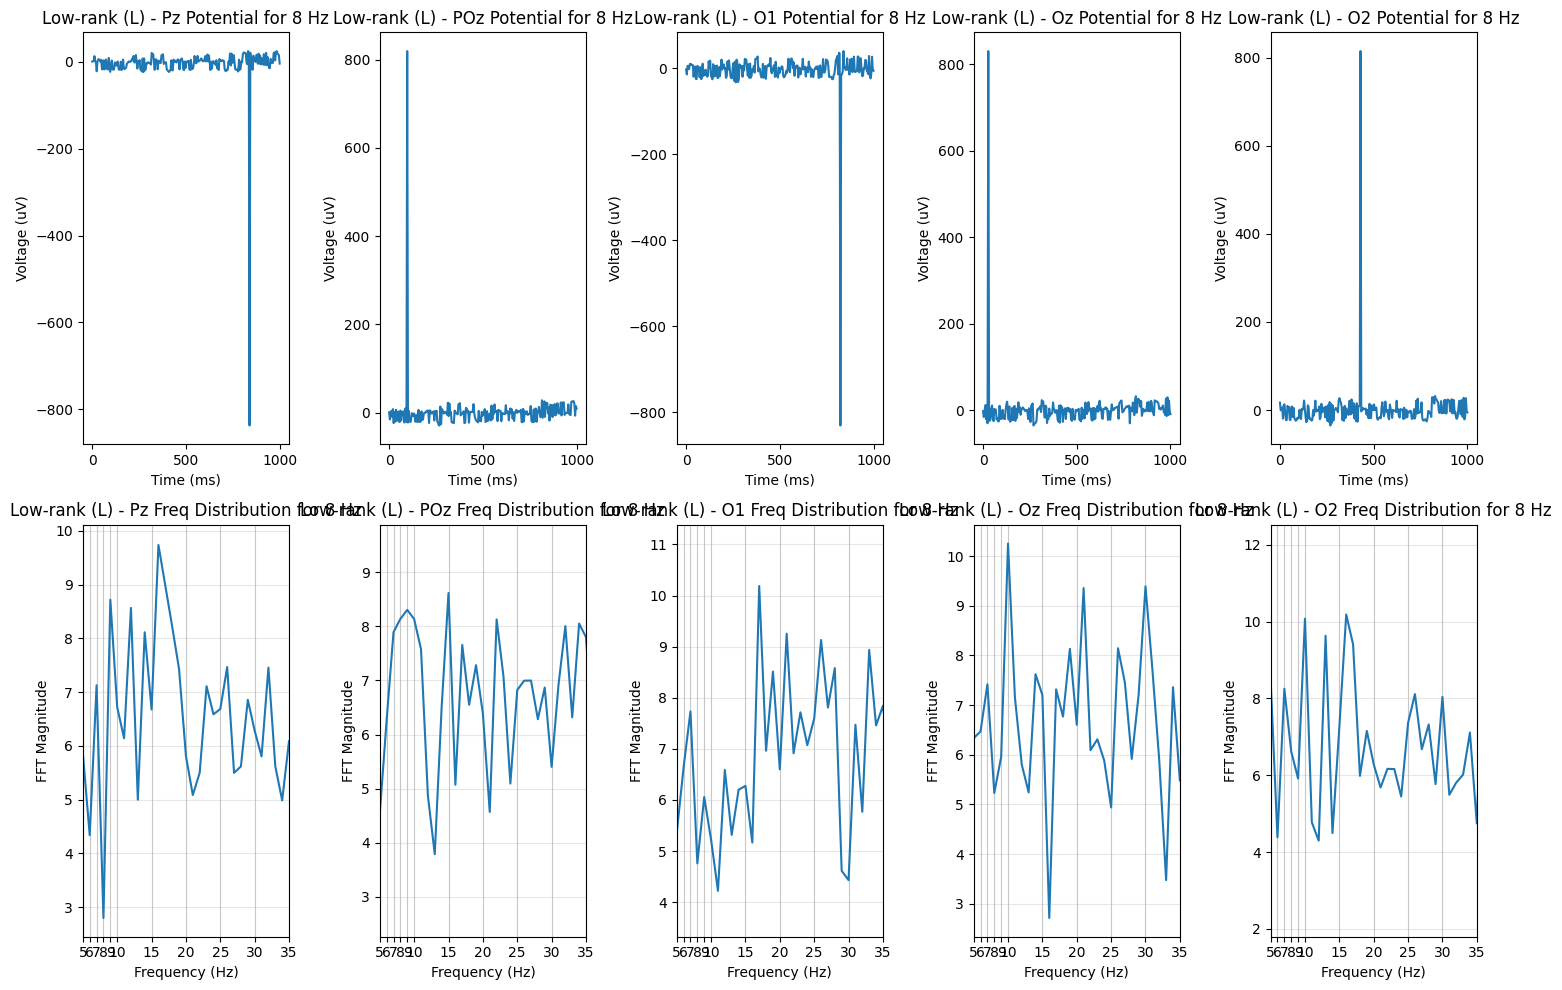

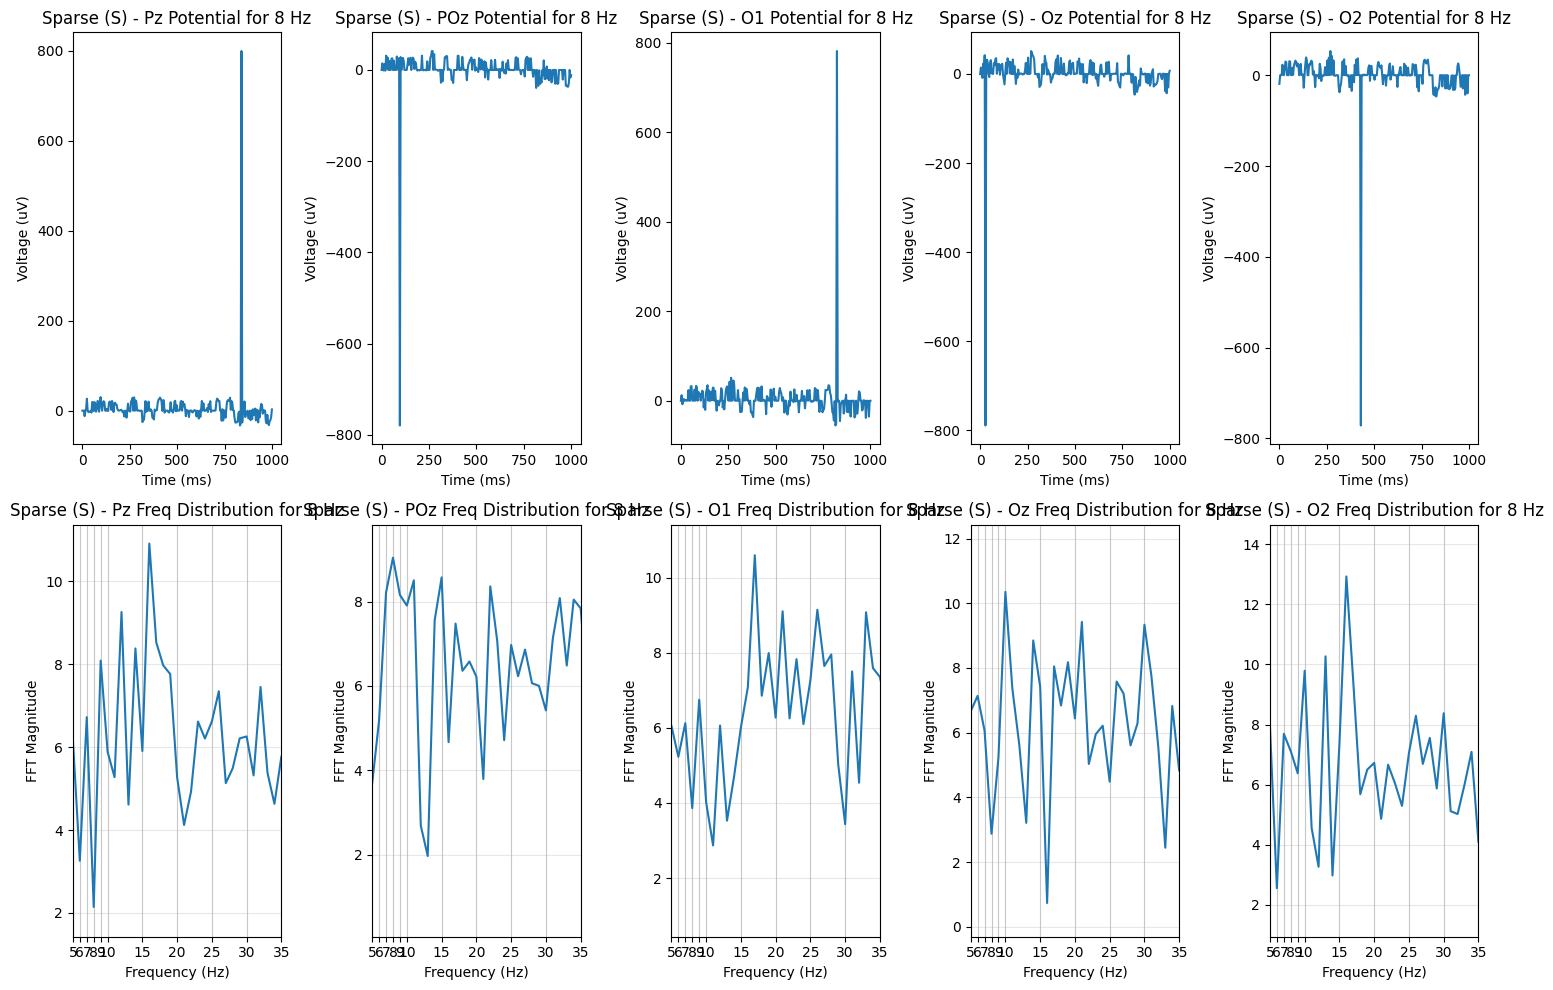

In [513]:
# Plot the L matrix (low-frequency component)
fig_L, axes_L = plot_time_frequency(
    data_matrix=electrode_data_filtered_L,
    channels=selected_channels,
    frequency=evoked_frequency,
    title_prefix="Low-rank (L)",
    show_grid=True
)

# Plot the S matrix (noise/sparsity component)
fig_S, axes_S = plot_time_frequency(
    data_matrix=electrode_data_filtered_S,
    channels=selected_channels,
    frequency=evoked_frequency,
    title_prefix="Sparse (S)",
    show_grid=True
)

### Power Spectral Density

In [514]:
# Calculate ratios for original data and filtered components
data_matrix = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)

# Calculate band-to-total power ratios
original_ratios = calculate_band_to_total_ratio(data_matrix)
L_ratios = calculate_band_to_total_ratio(electrode_data_filtered_L)
S_ratios = calculate_band_to_total_ratio(electrode_data_filtered_S)

# Display the table of band-to-total power ratios
ratios_table = display_power_ratios_table(original_ratios, L_ratios, S_ratios, list(selected_channels.keys()))
print("Band-to-total power ratios for each channel:")
print(ratios_table)

Band-to-total power ratios for each channel:
Channel            Pz       POz        O1        Oz        O2
Component                                                    
Original     0.032105  0.039103  0.109949  0.089919  0.118187
L component  0.291535  0.082907  0.051002  0.050923  0.065377
S component  0.211174  0.088847  0.057631  0.063109  0.064492
